In [2]:
import copy
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)    
matplotlib.rcParams['axes.unicode_minus'] = False      
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 150)

from xgboost import XGBRegressor

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.set_printoptions(sci_mode=False)
random_seed = 616

### 기본 데이터

In [3]:
y_col = '유입량'
PK_col = ['홍수사상번호','연','월','일','시간']

In [4]:
data_raw = pd.read_excel('../data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx', header=[0,1])
data_raw = data_raw.dropna()

data_raw.columns = ['_'.join(col).strip() if "Unnamed" not in col[1] else col[0] for col in data_raw.columns.values]

In [5]:
# 결과 값 저장할 dataframe 생성

predict_df = pd.DataFrame()
predict_df[PK_col] = data_raw[PK_col]
predict_df['true'] = data_raw.유입량

score_df = pd.DataFrame()

## source code

In [6]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layer=(1, 1, 1), batch_norm=True, drop_out=True, drop_prob=0.3):
        super().__init__()
        self.hidden_layer = self.make_layers(input_size, hidden_layer, batch_norm, drop_out, drop_prob)

    def forward(self, x):
        out = self.hidden_layer(x)
        return out

    def make_layers(self, input_size, hidden_layer, batch_norm, drop_out, drop_prob):
        layers = []
        in_size = input_size
        if hidden_layer[0] == 'R':
            for v in hidden_layer[1:]:
                out_size = int(v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size
        else:
            for v in hidden_layer:
                out_size = int(input_size * v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size

        linear = nn.Linear(out_size, 1)
        torch.nn.init.xavier_uniform_(linear.weight)
        layers += [linear]

        return nn.Sequential(*layers)

In [7]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [8]:
first_values = data_raw.groupby('홍수사상번호').first()['유입량']

def dnn_predict(name, data, model_structure, scaler, view=False, view_num=5, early_stop_num = 3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device
    pred_values = []
    predict_df = pd.DataFrame()
    predict_df[PK_col] = data[['홍수사상번호','연','월','일','시간']]
    predict_df['true'] = data.유입량
    
    for num in data.홍수사상번호.unique():
        print(f"홍수사상번호 {num} 시작")
        train = data[data['홍수사상번호'] != num].dropna().copy()
        valid = data[data['홍수사상번호'] == num].copy()

        X_train = train.drop(columns=[y_col]+PK_col)
        y_train = train[y_col]

        X_valid = valid.drop(columns=[y_col]+PK_col)
        y_valid = valid[y_col]
        
        scaler.fit(X_train)

        X_train_tensors = torch.Tensor(scaler.transform(X_train)).to(device)
        X_valid_tensors = torch.Tensor(scaler.transform(X_valid)).to(device)

        y_train_tensors = torch.Tensor(y_train.values).to(device)
        y_valid_tensors = torch.Tensor(y_valid.values).to(device)
        
        input_size = X_train.shape[1]

        dnn = DNN(input_size, model_structure["hidden_layer"], model_structure["batch_norm"],
                  model_structure["drop_out"], model_structure["drop_prob"]).to(device)
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(dnn.parameters(), lr=model_structure["learning_rate"])  # adam optimizer
        
        best_loss = 1E+10
        best_epoch = 0
        for epoch in range(model_structure["num_epochs"]):
            optimizer.zero_grad()
            outputs = dnn(X_train_tensors)
            loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                dnn.eval()
                outputs_valid = dnn(X_valid_tensors)
                loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
                if loss_valid < best_loss:
                    best_loss = loss_valid
                    best_epoch = epoch
                    pred_valid = list(outputs_valid.view(-1).detach().cpu().numpy())
                dnn.train()

            if view and ((epoch+1) % (model_structure["num_epochs"]//view_num) == 0):
                print("  Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))
            
            if (epoch - best_epoch) > (model_structure["num_epochs"] // early_stop_num):
                print("Best Epoch: %d Best Valid Loss: %1.2f" % (best_epoch+1, best_loss.item()))
                break
        print("")
        pred_values += pred_valid
    
    predict_df[f'pred_DNN_{name}'] = pred_values
    
    return predict_df

In [9]:
def fill_nan(predict_df):
    for num in predict_df.홍수사상번호:
        predict_num = predict_df[predict_df.홍수사상번호 == num]
        predict_num = predict_num.fillna(method='ffill').fillna(method='bfill')
        predict_df.loc[predict_df.홍수사상번호 == num] = predict_num
        
def rmse(predict_df, name):
    pred = predict_df[predict_df[f'pred_DNN_{name}'].notnull()][f'pred_DNN_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.sqrt(mean_squared_error(true, pred))

def rmsle(predict_df, name):
    pred = predict_df[predict_df[f'pred_DNN_{name}'].notnull()][f'pred_DNN_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.sqrt(mean_squared_log_error(true, pred))
    
def r2(predict_df, name):
    pred = predict_df[predict_df[f'pred_DNN_{name}'].notnull()][f'pred_DNN_{name}']
    true = predict_df.loc[pred.index]['true']
    return r2_score(true, pred)

def mape(predict_df, name):
    pred = predict_df[predict_df[f'pred_DNN_{name}'].notnull()][f'pred_DNN_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.mean(np.abs((true - pred) / true))*100

## model structure

In [10]:
model_structure = {
    "num_epochs" : 5000,
    "learning_rate" : 0.01,
    "hidden_layer" : (1,1),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

# Predict

In [11]:
name = 'base'

data_base = data_raw.copy()

In [11]:
predict_temp = dnn_predict(name, data_base, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 1129 Best Valid Loss: 1332343.75

홍수사상번호 2 시작
Best Epoch: 956 Best Valid Loss: 843630.62

홍수사상번호 3 시작
Best Epoch: 463 Best Valid Loss: 34313.84

홍수사상번호 4 시작
Best Epoch: 536 Best Valid Loss: 168384.53

홍수사상번호 5 시작
Best Epoch: 723 Best Valid Loss: 1091938.00

홍수사상번호 6 시작
Best Epoch: 1022 Best Valid Loss: 56260.73

홍수사상번호 7 시작
Best Epoch: 475 Best Valid Loss: 330567.34

홍수사상번호 8 시작
Best Epoch: 1213 Best Valid Loss: 505375.09

홍수사상번호 9 시작
Best Epoch: 1138 Best Valid Loss: 99163.77

홍수사상번호 10 시작
Best Epoch: 472 Best Valid Loss: 38363.58

홍수사상번호 11 시작
Best Epoch: 584 Best Valid Loss: 54500.73

홍수사상번호 12 시작
Best Epoch: 802 Best Valid Loss: 53528.83

홍수사상번호 13 시작
Best Epoch: 567 Best Valid Loss: 70862.98

홍수사상번호 14 시작
Best Epoch: 1455 Best Valid Loss: 210393.67

홍수사상번호 15 시작
Best Epoch: 1479 Best Valid Loss: 56741.99

홍수사상번호 16 시작
Best Epoch: 515 Best Valid Loss: 36144.69

홍수사상번호 17 시작
Best Epoch: 799 Best Valid Loss: 210762.16

홍수사상번호 18 시작
Best Epoch: 673 Best Valid L

In [12]:
predict_temp

,홍수사상번호,연,월,일,시간,true,pred_DNN_base
0,1,2006,7,10,8,189.10,53.00
1,1,2006,7,10,9,216.95,58.04
2,1,2006,7,10,10,251.42,61.05
3,1,2006,7,10,11,302.81,84.45
4,1,2006,7,10,12,384.78,111.07
...,...,...,...,...,...,...,...
2886,25,2017,7,18,18,513.37,467.88
2887,25,2017,7,18,19,502.85,467.89
2888,25,2017,7,18,20,491.95,463.96
2889,25,2017,7,18,21,481.10,455.38


In [13]:
if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

In [16]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22


# Predict_ 21 23 제외

In [18]:
name = 'base_2123'

data_2123 = data_raw[~data_raw.홍수사상번호.isin([21,23])].copy()

In [19]:
predict_temp = dnn_predict(name, data_2123, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 635 Best Valid Loss: 1254737.50

홍수사상번호 2 시작
Best Epoch: 1531 Best Valid Loss: 742068.25

홍수사상번호 3 시작
Best Epoch: 543 Best Valid Loss: 41095.60

홍수사상번호 4 시작
Best Epoch: 2211 Best Valid Loss: 97123.88

홍수사상번호 5 시작
Best Epoch: 1172 Best Valid Loss: 1072631.62

홍수사상번호 6 시작
Best Epoch: 643 Best Valid Loss: 53800.24

홍수사상번호 7 시작
Best Epoch: 536 Best Valid Loss: 329920.72

홍수사상번호 8 시작
Best Epoch: 723 Best Valid Loss: 509704.81

홍수사상번호 9 시작
Best Epoch: 792 Best Valid Loss: 60841.62

홍수사상번호 10 시작
Best Epoch: 1122 Best Valid Loss: 36408.52

홍수사상번호 11 시작
Best Epoch: 873 Best Valid Loss: 59691.95

홍수사상번호 12 시작
Best Epoch: 981 Best Valid Loss: 56554.71

홍수사상번호 13 시작
Best Epoch: 585 Best Valid Loss: 68620.15

홍수사상번호 14 시작
Best Epoch: 982 Best Valid Loss: 208820.28

홍수사상번호 15 시작
Best Epoch: 963 Best Valid Loss: 52347.27

홍수사상번호 16 시작
Best Epoch: 535 Best Valid Loss: 14384.09

홍수사상번호 17 시작
Best Epoch: 934 Best Valid Loss: 216754.38

홍수사상번호 18 시작
Best Epoch: 620 Best Valid Loss

In [20]:
if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

In [21]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60


## 모든 데이터 t-1 t+1

In [22]:
name = 't-1 t+1'

data_t = data_raw.copy()

for col in data_t.columns.difference([y_col] + PK_col):
    data_t[f'{col}_shift 1'] = data_t[col].shift()
    data_t[f'{col}_shift1 -1'] = data_t[col].shift(-1)

shift_col = data_t.filter(regex='shift').columns
data_t['홍수사상번호_shift 1'] = data_t['홍수사상번호'].shift()
data_t['홍수사상번호_shift -1'] = data_t['홍수사상번호'].shift(-1)

data_t.loc[(data_t['홍수사상번호'] != data_t['홍수사상번호_shift 1']), shift_col] = np.nan
data_t.loc[(data_t['홍수사상번호'] != data_t['홍수사상번호_shift -1']), shift_col] = np.nan

data_t = data_t.dropna()

In [23]:
predict_temp = dnn_predict(name, data_t, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 319 Best Valid Loss: 1080249.25

홍수사상번호 2 시작
Best Epoch: 677 Best Valid Loss: 669762.75

홍수사상번호 3 시작
Best Epoch: 249 Best Valid Loss: 39732.82

홍수사상번호 4 시작
Best Epoch: 325 Best Valid Loss: 111765.02

홍수사상번호 5 시작
Best Epoch: 751 Best Valid Loss: 970800.19

홍수사상번호 6 시작
Best Epoch: 288 Best Valid Loss: 48112.80

홍수사상번호 7 시작
Best Epoch: 272 Best Valid Loss: 335319.00

홍수사상번호 8 시작
Best Epoch: 425 Best Valid Loss: 508224.25

홍수사상번호 9 시작
Best Epoch: 422 Best Valid Loss: 81356.65

홍수사상번호 10 시작
Best Epoch: 290 Best Valid Loss: 41150.51

홍수사상번호 11 시작
Best Epoch: 330 Best Valid Loss: 36444.46

홍수사상번호 12 시작
Best Epoch: 412 Best Valid Loss: 76724.09

홍수사상번호 13 시작
Best Epoch: 1063 Best Valid Loss: 43312.21

홍수사상번호 14 시작
Best Epoch: 1438 Best Valid Loss: 128669.80

홍수사상번호 15 시작
Best Epoch: 980 Best Valid Loss: 35033.50

홍수사상번호 16 시작
Best Epoch: 284 Best Valid Loss: 29286.99

홍수사상번호 17 시작
Best Epoch: 646 Best Valid Loss: 119746.62

홍수사상번호 18 시작
Best Epoch: 1413 Best Valid Loss:

In [24]:
if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

In [25]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17


## 수위 E 지역만 t-1 t+1

In [26]:
name = 'waterlevel t-1 t+1'

data_waterlevel_t = data_raw.copy()

waterlevel_col = data_waterlevel_t.filter(regex='수위\(E지역\)')
for col in waterlevel_col:
    data_waterlevel_t[f'{col}_shift 1'] = data_waterlevel_t[col].shift()
    data_waterlevel_t[f'{col}_shift1 -1'] = data_waterlevel_t[col].shift(-1)

shift_col = data_waterlevel_t.filter(regex='shift').columns
data_waterlevel_t['홍수사상번호_shift 1'] = data_waterlevel_t['홍수사상번호'].shift()
data_waterlevel_t['홍수사상번호_shift -1'] = data_waterlevel_t['홍수사상번호'].shift(-1)

data_waterlevel_t.loc[(data_waterlevel_t['홍수사상번호'] != data_waterlevel_t['홍수사상번호_shift 1']), shift_col] = np.nan
data_waterlevel_t.loc[(data_waterlevel_t['홍수사상번호'] != data_waterlevel_t['홍수사상번호_shift -1']), shift_col] = np.nan

data_waterlevel_t = data_waterlevel_t.dropna()

In [27]:
predict_temp = dnn_predict(name, data_waterlevel_t, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 480 Best Valid Loss: 1751943.50

홍수사상번호 2 시작
Best Epoch: 788 Best Valid Loss: 889346.44

홍수사상번호 3 시작
Best Epoch: 384 Best Valid Loss: 49050.26

홍수사상번호 4 시작
Best Epoch: 696 Best Valid Loss: 51009.26

홍수사상번호 5 시작
Best Epoch: 688 Best Valid Loss: 1127528.25

홍수사상번호 6 시작
Best Epoch: 434 Best Valid Loss: 74018.07

홍수사상번호 7 시작
Best Epoch: 499 Best Valid Loss: 335461.19

홍수사상번호 8 시작
Best Epoch: 564 Best Valid Loss: 463041.91

홍수사상번호 9 시작
Best Epoch: 725 Best Valid Loss: 85697.84

홍수사상번호 10 시작
Best Epoch: 492 Best Valid Loss: 43424.26

홍수사상번호 11 시작
Best Epoch: 597 Best Valid Loss: 37493.73

홍수사상번호 12 시작
Best Epoch: 660 Best Valid Loss: 69342.12

홍수사상번호 13 시작
Best Epoch: 537 Best Valid Loss: 54140.83

홍수사상번호 14 시작
Best Epoch: 932 Best Valid Loss: 187249.03

홍수사상번호 15 시작
Best Epoch: 774 Best Valid Loss: 47417.83

홍수사상번호 16 시작
Best Epoch: 432 Best Valid Loss: 28022.94

홍수사상번호 17 시작
Best Epoch: 969 Best Valid Loss: 197352.69

홍수사상번호 18 시작
Best Epoch: 419 Best Valid Loss: 15

In [28]:
if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

In [29]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17
waterlevel t-1 t+1,532.76,0.44,0.94,23.27


## 클러스터링 넣기

In [30]:
for n in range(3,7):
    print('------------------')
    print(f"Clustering K : {n} Start")
    print('------------------')
    
    name = f'{n} cluster'

    data_cluster = data_raw.copy()

    clustering_df = pd.read_csv(f'../data/clustering/{n}_clustering_result.csv',index_col=0)
    cluster_list = [f'k{i}' for i in range(n)]
    
    data_cluster[cluster_list] = clustering_df
    
    predict_temp = dnn_predict(name, data_cluster, model_structure, robust_scaler, view=False, early_stop_num=10)
    
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
    score_df.loc[name, "RMSE"] = rmse(predict_df,name)
    score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
    score_df.loc[name, "R2_score"] = r2(predict_df,name)
    score_df.loc[name, "MAPE"] = mape(predict_df,name)

------------------
Clustering K : 3 Start
------------------
홍수사상번호 1 시작
Best Epoch: 600 Best Valid Loss: 1422325.12

홍수사상번호 2 시작
Best Epoch: 708 Best Valid Loss: 1052987.88

홍수사상번호 3 시작
Best Epoch: 421 Best Valid Loss: 50087.76

홍수사상번호 4 시작
Best Epoch: 672 Best Valid Loss: 208287.12

홍수사상번호 5 시작
Best Epoch: 690 Best Valid Loss: 1044796.81

홍수사상번호 6 시작
Best Epoch: 538 Best Valid Loss: 57233.73

홍수사상번호 7 시작
Best Epoch: 509 Best Valid Loss: 388510.12

홍수사상번호 8 시작
Best Epoch: 772 Best Valid Loss: 432613.16

홍수사상번호 9 시작
Best Epoch: 637 Best Valid Loss: 137362.44

홍수사상번호 10 시작
Best Epoch: 562 Best Valid Loss: 52435.02

홍수사상번호 11 시작
Best Epoch: 803 Best Valid Loss: 65000.37

홍수사상번호 12 시작
Best Epoch: 775 Best Valid Loss: 51139.36

홍수사상번호 13 시작
Best Epoch: 914 Best Valid Loss: 73014.31

홍수사상번호 14 시작
Best Epoch: 1021 Best Valid Loss: 209186.94

홍수사상번호 15 시작
Best Epoch: 1177 Best Valid Loss: 63213.96

홍수사상번호 16 시작
Best Epoch: 469 Best Valid Loss: 39566.89

홍수사상번호 17 시작
Best Epoch: 771 Best Valid

In [31]:
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17
waterlevel t-1 t+1,532.76,0.44,0.94,23.27
3 cluster,524.74,0.63,0.94,26.29
4 cluster,468.06,0.54,0.95,24.76
5 cluster,500.41,0.58,0.95,25.04
6 cluster,500.88,0.41,0.95,23.13


## log 변환

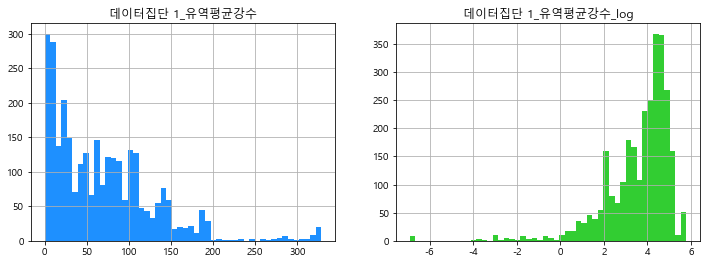

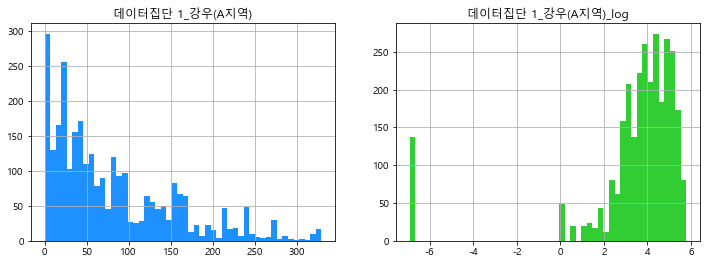

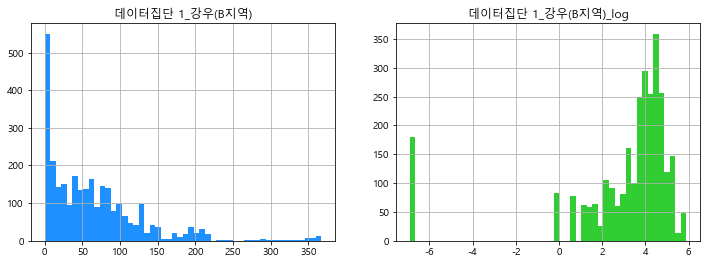

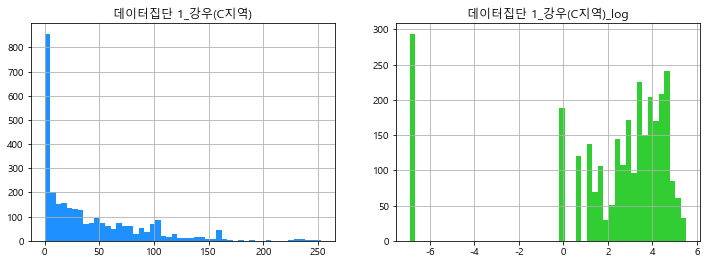

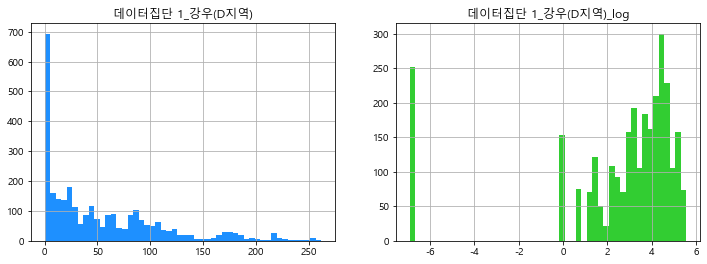

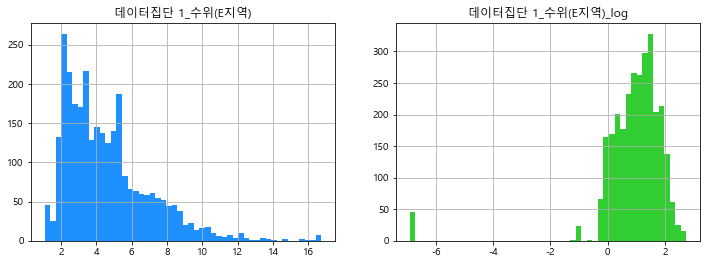

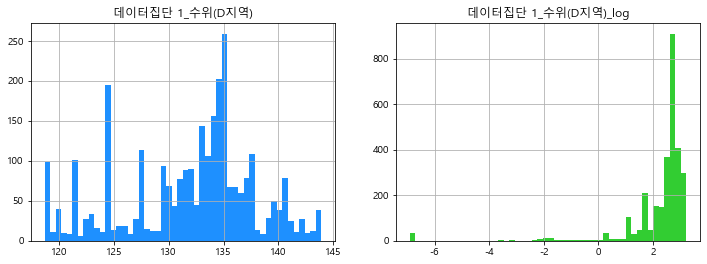

In [53]:
for col in data_raw.filter(regex='데이터집단 1').columns:
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1, 2, 1)
    data_raw[col].hist(bins=50, ax=ax1, color='dodgerblue')
    ax1.set_title(col)
    
    ax2 = fig.add_subplot(1, 2, 2)
    np.log(data_raw[col] - data_raw[col].min() + 0.001).hist(bins=50, ax=ax2, color='limegreen')
    ax2.set_title(col + '_log')
    plt.show()

In [33]:
name = 'log'
data_log = data_raw.copy()

log_col = data_log.columns.difference(list(data_log.filter(regex="수위\(D지역\)").columns) + [y_col] + PK_col)
for col in log_col:
    data_log[col + '_zero'] = (data_log[col] == 0).astype(int)
    data_log[col] = data_log[col].apply(lambda x : np.log(x - data_log[col].min() + 0.01))

In [34]:
predict_temp = dnn_predict(name, data_log, model_structure, robust_scaler, view=False, early_stop_num=10)

if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

홍수사상번호 1 시작
Best Epoch: 555 Best Valid Loss: 2717435.25

홍수사상번호 2 시작
Best Epoch: 461 Best Valid Loss: 860662.69

홍수사상번호 3 시작
Best Epoch: 313 Best Valid Loss: 76703.32

홍수사상번호 4 시작
Best Epoch: 363 Best Valid Loss: 104354.13

홍수사상번호 5 시작
Best Epoch: 1401 Best Valid Loss: 1549518.25

홍수사상번호 6 시작
Best Epoch: 1590 Best Valid Loss: 35225.23

홍수사상번호 7 시작
Best Epoch: 518 Best Valid Loss: 186327.58

홍수사상번호 8 시작
Best Epoch: 779 Best Valid Loss: 401936.22

홍수사상번호 9 시작
Best Epoch: 749 Best Valid Loss: 89556.81

홍수사상번호 10 시작
Best Epoch: 329 Best Valid Loss: 49926.69

홍수사상번호 11 시작
Best Epoch: 448 Best Valid Loss: 31527.49

홍수사상번호 12 시작
Best Epoch: 818 Best Valid Loss: 127564.79

홍수사상번호 13 시작
Best Epoch: 390 Best Valid Loss: 116041.41

홍수사상번호 14 시작
Best Epoch: 1502 Best Valid Loss: 185118.16

홍수사상번호 15 시작
Best Epoch: 463 Best Valid Loss: 60155.50

홍수사상번호 16 시작
Best Epoch: 359 Best Valid Loss: 23789.79

홍수사상번호 17 시작
Best Epoch: 1669 Best Valid Loss: 101003.45

홍수사상번호 18 시작
Best Epoch: 469 Best Valid L

In [35]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [36]:
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17
waterlevel t-1 t+1,532.76,0.44,0.94,23.27
3 cluster,524.74,0.63,0.94,26.29
4 cluster,468.06,0.54,0.95,24.76
5 cluster,500.41,0.58,0.95,25.04
6 cluster,500.88,0.41,0.95,23.13
log,613.79,0.70,0.92,43.35


## origin + log 변환

In [37]:
name = 'origin + log'
data_originlog = data_raw.copy()

log_col = data_originlog.columns.difference(list(data_originlog.filter(regex="수위\(E지역\)").columns) + [y_col] + PK_col)
for col in log_col:
    data_originlog[col + '_zero'] = (data_originlog[col] == 0).astype(int)
    data_originlog[col + '_log'] = data_originlog[col].apply(lambda x : np.log(x - data_originlog[col].min() + 0.01))

In [38]:
predict_temp = dnn_predict(name, data_originlog, model_structure, robust_scaler, view=False, early_stop_num=10)

if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

홍수사상번호 1 시작
Best Epoch: 776 Best Valid Loss: 1030677.38

홍수사상번호 2 시작
Best Epoch: 1313 Best Valid Loss: 734748.44

홍수사상번호 3 시작
Best Epoch: 259 Best Valid Loss: 58277.25

홍수사상번호 4 시작
Best Epoch: 339 Best Valid Loss: 168280.70

홍수사상번호 5 시작
Best Epoch: 452 Best Valid Loss: 1427159.12

홍수사상번호 6 시작
Best Epoch: 283 Best Valid Loss: 66642.29

홍수사상번호 7 시작
Best Epoch: 319 Best Valid Loss: 344870.09

홍수사상번호 8 시작
Best Epoch: 541 Best Valid Loss: 357190.62

홍수사상번호 9 시작
Best Epoch: 714 Best Valid Loss: 40690.54

홍수사상번호 10 시작
Best Epoch: 298 Best Valid Loss: 37282.11

홍수사상번호 11 시작
Best Epoch: 467 Best Valid Loss: 45972.23

홍수사상번호 12 시작
Best Epoch: 462 Best Valid Loss: 83266.69

홍수사상번호 13 시작
Best Epoch: 443 Best Valid Loss: 88059.12

홍수사상번호 14 시작
Best Epoch: 539 Best Valid Loss: 183593.83

홍수사상번호 15 시작
Best Epoch: 431 Best Valid Loss: 70475.73

홍수사상번호 16 시작
Best Epoch: 298 Best Valid Loss: 23243.59

홍수사상번호 17 시작
Best Epoch: 439 Best Valid Loss: 235167.08

홍수사상번호 18 시작
Best Epoch: 429 Best Valid Loss: 

In [39]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [40]:
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17
waterlevel t-1 t+1,532.76,0.44,0.94,23.27
3 cluster,524.74,0.63,0.94,26.29
4 cluster,468.06,0.54,0.95,24.76
5 cluster,500.41,0.58,0.95,25.04
6 cluster,500.88,0.41,0.95,23.13
log,613.79,0.70,0.92,43.35
origin + log,494.40,0.41,0.95,29.15


## x^2 변환

In [41]:
name = 'x2'
data_x2 = data_raw.copy()

x2_col = data_x2.filter(regex="수위\(E지역\)").columns
for col in x2_col:
    data_x2[col + '_x2'] = data_x2[col] ** 2

In [42]:
predict_temp = dnn_predict(name, data_x2, model_structure, robust_scaler, view=False, early_stop_num=10)

if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

홍수사상번호 1 시작
Best Epoch: 775 Best Valid Loss: 737961.94

홍수사상번호 2 시작
Best Epoch: 669 Best Valid Loss: 753426.69

홍수사상번호 3 시작
Best Epoch: 418 Best Valid Loss: 44988.64

홍수사상번호 4 시작
Best Epoch: 536 Best Valid Loss: 210972.62

홍수사상번호 5 시작
Best Epoch: 831 Best Valid Loss: 1205128.88

홍수사상번호 6 시작
Best Epoch: 508 Best Valid Loss: 58102.50

홍수사상번호 7 시작
Best Epoch: 502 Best Valid Loss: 173038.64

홍수사상번호 8 시작
Best Epoch: 1177 Best Valid Loss: 498485.62

홍수사상번호 9 시작
Best Epoch: 735 Best Valid Loss: 73421.08

홍수사상번호 10 시작
Best Epoch: 474 Best Valid Loss: 38584.29

홍수사상번호 11 시작
Best Epoch: 549 Best Valid Loss: 60156.48

홍수사상번호 12 시작
Best Epoch: 604 Best Valid Loss: 49753.95

홍수사상번호 13 시작
Best Epoch: 664 Best Valid Loss: 73516.46

홍수사상번호 14 시작
Best Epoch: 2793 Best Valid Loss: 172977.75

홍수사상번호 15 시작
Best Epoch: 971 Best Valid Loss: 43390.76

홍수사상번호 16 시작
Best Epoch: 447 Best Valid Loss: 35965.86

홍수사상번호 17 시작
Best Epoch: 692 Best Valid Loss: 196042.00

홍수사상번호 18 시작
Best Epoch: 617 Best Valid Loss: 

In [43]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [44]:
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17
waterlevel t-1 t+1,532.76,0.44,0.94,23.27
3 cluster,524.74,0.63,0.94,26.29
4 cluster,468.06,0.54,0.95,24.76
5 cluster,500.41,0.58,0.95,25.04
6 cluster,500.88,0.41,0.95,23.13
log,613.79,0.70,0.92,43.35
origin + log,494.40,0.41,0.95,29.15


## clustering  + x2

In [45]:
n = 5
name = f'{n}cluster + x2'

data_cluster_x2 = data_raw.copy()

x2_col = data_cluster_x2.filter(regex="수위\(E지역\)").columns
for col in x2_col:
    data_cluster_x2[col + '_x2'] = data_cluster_x2[col] ** 2

clustering_df = pd.read_csv(f'../data/clustering/{n}_clustering_result.csv',index_col=0)
cluster_list = [f'k{i}' for i in range(n)]

data_cluster_x2[cluster_list] = clustering_df

data_cluster_x2 = data_cluster_x2.dropna()

In [46]:
predict_temp = dnn_predict(name, data_cluster_x2, model_structure, robust_scaler, view=False, early_stop_num=10)

if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

홍수사상번호 1 시작
Best Epoch: 1269 Best Valid Loss: 616796.25

홍수사상번호 2 시작
Best Epoch: 829 Best Valid Loss: 960755.69

홍수사상번호 3 시작
Best Epoch: 401 Best Valid Loss: 61431.17

홍수사상번호 4 시작
Best Epoch: 409 Best Valid Loss: 264694.12

홍수사상번호 5 시작
Best Epoch: 1818 Best Valid Loss: 1125894.12

홍수사상번호 6 시작
Best Epoch: 912 Best Valid Loss: 48780.19

홍수사상번호 7 시작
Best Epoch: 478 Best Valid Loss: 232475.22

홍수사상번호 8 시작
Best Epoch: 711 Best Valid Loss: 311711.12

홍수사상번호 9 시작
Best Epoch: 687 Best Valid Loss: 45481.97

홍수사상번호 10 시작
Best Epoch: 408 Best Valid Loss: 36457.14

홍수사상번호 11 시작
Best Epoch: 656 Best Valid Loss: 70253.25

홍수사상번호 12 시작
Best Epoch: 598 Best Valid Loss: 96923.85

홍수사상번호 13 시작
Best Epoch: 1241 Best Valid Loss: 63808.75

홍수사상번호 14 시작
Best Epoch: 835 Best Valid Loss: 268254.72

홍수사상번호 15 시작
Best Epoch: 1120 Best Valid Loss: 55746.98

홍수사상번호 16 시작
Best Epoch: 455 Best Valid Loss: 32273.83

홍수사상번호 17 시작
Best Epoch: 707 Best Valid Loss: 182449.89

홍수사상번호 18 시작
Best Epoch: 572 Best Valid Loss

In [47]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [48]:
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17
waterlevel t-1 t+1,532.76,0.44,0.94,23.27
3 cluster,524.74,0.63,0.94,26.29
4 cluster,468.06,0.54,0.95,24.76
5 cluster,500.41,0.58,0.95,25.04
6 cluster,500.88,0.41,0.95,23.13
log,613.79,0.70,0.92,43.35
origin + log,494.40,0.41,0.95,29.15


## clustering + t-1 t+1

In [49]:
n = 5
name = f'{n}cluster + t'

data_cluster_t = data_raw.copy()

x2_col = data_cluster_t.filter(regex="수위\(E지역\)").columns
for col in x2_col:
    data_cluster_t[col + '_x2'] = data_cluster_t[col] ** 2

clustering_df = pd.read_csv(f'../data/clustering/{n}_clustering_result.csv',index_col=0)
cluster_list = [f'k{i}' for i in range(n)]

data_cluster_t[cluster_list] = clustering_df

for col in data_cluster_t.columns.difference([y_col] + PK_col + cluster_list):
    data_cluster_t[f'{col}_shift 1'] = data_cluster_t[col].shift()
    data_cluster_t[f'{col}_shift1 -1'] = data_cluster_t[col].shift(-1)

shift_col = data_cluster_t.filter(regex='shift').columns
data_cluster_t['홍수사상번호_shift 1'] = data_cluster_t['홍수사상번호'].shift()
data_cluster_t['홍수사상번호_shift -1'] = data_cluster_t['홍수사상번호'].shift(-1)

data_cluster_t.loc[(data_cluster_t['홍수사상번호'] != data_cluster_t['홍수사상번호_shift 1']), shift_col] = np.nan
data_cluster_t.loc[(data_cluster_t['홍수사상번호'] != data_cluster_t['홍수사상번호_shift -1']), shift_col] = np.nan


data_cluster_t = data_cluster_t.dropna()

In [50]:
predict_temp = dnn_predict(name, data_cluster_t, model_structure, robust_scaler, view=False, early_stop_num=10)

if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

홍수사상번호 1 시작
Best Epoch: 251 Best Valid Loss: 835385.44

홍수사상번호 2 시작
Best Epoch: 435 Best Valid Loss: 652143.56

홍수사상번호 3 시작
Best Epoch: 216 Best Valid Loss: 43443.43

홍수사상번호 4 시작
Best Epoch: 236 Best Valid Loss: 213435.45

홍수사상번호 5 시작
Best Epoch: 545 Best Valid Loss: 1240822.25

홍수사상번호 6 시작
Best Epoch: 380 Best Valid Loss: 24538.87

홍수사상번호 7 시작
Best Epoch: 262 Best Valid Loss: 222767.23

홍수사상번호 8 시작
Best Epoch: 467 Best Valid Loss: 428170.81

홍수사상번호 9 시작
Best Epoch: 545 Best Valid Loss: 69207.98

홍수사상번호 10 시작
Best Epoch: 254 Best Valid Loss: 21836.09

홍수사상번호 11 시작
Best Epoch: 331 Best Valid Loss: 41644.98

홍수사상번호 12 시작
Best Epoch: 376 Best Valid Loss: 90273.70

홍수사상번호 13 시작
Best Epoch: 2551 Best Valid Loss: 25964.97

홍수사상번호 14 시작
Best Epoch: 564 Best Valid Loss: 174271.31

홍수사상번호 15 시작
Best Epoch: 1000 Best Valid Loss: 44138.52

홍수사상번호 16 시작
Best Epoch: 275 Best Valid Loss: 26011.40

홍수사상번호 17 시작
Best Epoch: 991 Best Valid Loss: 131359.30

홍수사상번호 18 시작
Best Epoch: 335 Best Valid Loss: 

In [51]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [52]:
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17
waterlevel t-1 t+1,532.76,0.44,0.94,23.27
3 cluster,524.74,0.63,0.94,26.29
4 cluster,468.06,0.54,0.95,24.76
5 cluster,500.41,0.58,0.95,25.04
6 cluster,500.88,0.41,0.95,23.13
log,613.79,0.70,0.92,43.35
origin + log,494.40,0.41,0.95,29.15


## t-1 t+1 + x2

In [47]:
model_structure = {
    "num_epochs" : 5000,
    "learning_rate" : 0.01,
    "hidden_layer" : (2,2,2,0.5),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

In [48]:
n = 5
name = f't + x2_{str(model_structure["hidden_layer"])}'

data_t_x2 = data_raw.copy()

x2_col = data_t_x2.filter(regex="수위\(E지역\)").columns
for col in x2_col:
    data_t_x2[col + '_x2'] = data_t_x2[col] ** 2

for col in data_t_x2.columns.difference([y_col] + PK_col):
    data_t_x2[f'{col}_shift 1'] = data_t_x2[col].shift()
    data_t_x2[f'{col}_shift1 -1'] = data_t_x2[col].shift(-1)

shift_col = data_t_x2.filter(regex='shift').columns
data_t_x2['홍수사상번호_shift 1'] = data_t_x2['홍수사상번호'].shift()
data_t_x2['홍수사상번호_shift -1'] = data_t_x2['홍수사상번호'].shift(-1)

data_t_x2.loc[(data_t_x2['홍수사상번호'] != data_t_x2['홍수사상번호_shift 1']), shift_col] = np.nan
data_t_x2.loc[(data_t_x2['홍수사상번호'] != data_t_x2['홍수사상번호_shift -1']), shift_col] = np.nan

data_t_x2 = data_t_x2.dropna()

In [49]:
predict_temp = dnn_predict(name, data_t_x2, model_structure, robust_scaler, view=False, early_stop_num=10)

if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

홍수사상번호 1 시작
Best Epoch: 433 Best Valid Loss: 1164978.38

홍수사상번호 2 시작
Best Epoch: 469 Best Valid Loss: 713108.56

홍수사상번호 3 시작
Best Epoch: 303 Best Valid Loss: 72921.66

홍수사상번호 4 시작
Best Epoch: 374 Best Valid Loss: 121345.09

홍수사상번호 5 시작
Best Epoch: 1119 Best Valid Loss: 1304441.88

홍수사상번호 6 시작
Best Epoch: 429 Best Valid Loss: 96070.05

홍수사상번호 7 시작
Best Epoch: 467 Best Valid Loss: 208139.47

홍수사상번호 8 시작
Best Epoch: 644 Best Valid Loss: 506390.38

홍수사상번호 9 시작
Best Epoch: 518 Best Valid Loss: 131568.39

홍수사상번호 10 시작
Best Epoch: 368 Best Valid Loss: 15114.75

홍수사상번호 11 시작
Best Epoch: 424 Best Valid Loss: 24662.66

홍수사상번호 12 시작
Best Epoch: 524 Best Valid Loss: 95998.54

홍수사상번호 13 시작
Best Epoch: 776 Best Valid Loss: 43648.68

홍수사상번호 14 시작
Best Epoch: 523 Best Valid Loss: 152644.25

홍수사상번호 15 시작
Best Epoch: 533 Best Valid Loss: 93785.01

홍수사상번호 16 시작
Best Epoch: 357 Best Valid Loss: 28376.61

홍수사상번호 17 시작
Best Epoch: 935 Best Valid Loss: 187785.84

홍수사상번호 18 시작
Best Epoch: 514 Best Valid Loss:

In [50]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [51]:
score_df

,RMSE,RMSLE,R2_score,MAPE
"t + x2_(1,1)",433.81,0.43,0.96,23.75
"t + x2_(2,2)",416.19,0.57,0.96,23.67
"t + x2_(2,2,2)",426.15,0.71,0.96,23.67
"t + x2_(2, 2, 2)",419.29,0.73,0.96,22.60
"t + x2_(0.5, 0.5)",457.90,0.39,0.96,22.97
"t + x2_(2, 1, 0.5)",437.21,0.44,0.96,22.69
"t + x2_(2, 2, 2, 0.5)",495.40,0.36,0.95,28.38


## 5 clustering + t-1 t+1 + x2

In [57]:
n = 5
name = f'{n}cluster + t + x2'

data_cluster_t_x2 = data_raw.copy()

x2_col = data_cluster_t_x2.filter(regex="수위\(E지역\)").columns
for col in x2_col:
    data_cluster_t_x2[col + '_x2'] = data_cluster_t_x2[col] ** 2

clustering_df = pd.read_csv(f'../data/clustering/{n}_clustering_result.csv',index_col=0)
cluster_list = [f'k{i}' for i in range(n)]

data_cluster_t_x2[cluster_list] = clustering_df

for col in data_cluster_t_x2.columns.difference([y_col] + PK_col + cluster_list):
    data_cluster_t_x2[f'{col}_shift 1'] = data_cluster_t_x2[col].shift()
    data_cluster_t_x2[f'{col}_shift1 -1'] = data_cluster_t_x2[col].shift(-1)

shift_col = data_cluster_t_x2.filter(regex='shift').columns
data_cluster_t_x2['홍수사상번호_shift 1'] = data_cluster_t_x2['홍수사상번호'].shift()
data_cluster_t_x2['홍수사상번호_shift -1'] = data_cluster_t_x2['홍수사상번호'].shift(-1)

data_cluster_t_x2.loc[(data_cluster_t_x2['홍수사상번호'] != data_cluster_t_x2['홍수사상번호_shift 1']), shift_col] = np.nan
data_cluster_t_x2.loc[(data_cluster_t_x2['홍수사상번호'] != data_cluster_t_x2['홍수사상번호_shift -1']), shift_col] = np.nan


data_cluster_t_x2 = data_cluster_t_x2.dropna()

In [58]:
predict_temp = dnn_predict(name, data_cluster_t_x2, model_structure, robust_scaler, view=False, early_stop_num=10)

if predict_temp.columns.isin(predict_df.columns).all():
    columns = predict_temp.columns.difference(PK_col+['true'])
    predict_df[columns] = predict_temp[columns]
else:
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
if not predict_temp.index.equals(predict_df.index):
    fill_nan(predict_df)

홍수사상번호 1 시작
Best Epoch: 268 Best Valid Loss: 879881.75

홍수사상번호 2 시작
Best Epoch: 389 Best Valid Loss: 627226.88

홍수사상번호 3 시작
Best Epoch: 208 Best Valid Loss: 43827.57

홍수사상번호 4 시작
Best Epoch: 238 Best Valid Loss: 176694.62

홍수사상번호 5 시작
Best Epoch: 314 Best Valid Loss: 1188815.00

홍수사상번호 6 시작
Best Epoch: 538 Best Valid Loss: 26276.35

홍수사상번호 7 시작
Best Epoch: 279 Best Valid Loss: 230052.12

홍수사상번호 8 시작
Best Epoch: 430 Best Valid Loss: 423745.50

홍수사상번호 9 시작
Best Epoch: 701 Best Valid Loss: 67563.46

홍수사상번호 10 시작
Best Epoch: 234 Best Valid Loss: 23305.38

홍수사상번호 11 시작
Best Epoch: 304 Best Valid Loss: 43341.65

홍수사상번호 12 시작
Best Epoch: 462 Best Valid Loss: 122177.91

홍수사상번호 13 시작
Best Epoch: 2651 Best Valid Loss: 25060.25

홍수사상번호 14 시작
Best Epoch: 570 Best Valid Loss: 188842.25

홍수사상번호 15 시작
Best Epoch: 724 Best Valid Loss: 40099.48

홍수사상번호 16 시작
Best Epoch: 286 Best Valid Loss: 41250.83

홍수사상번호 17 시작
Best Epoch: 884 Best Valid Loss: 150426.78

홍수사상번호 18 시작
Best Epoch: 530 Best Valid Loss: 

In [59]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [60]:
score_df

,RMSE,RMSLE,R2_score,MAPE
base,509.75,0.45,0.95,24.22
base_2123,490.85,0.47,0.95,26.60
t-1 t+1,465.12,0.34,0.95,21.17
waterlevel t-1 t+1,532.76,0.44,0.94,23.27
3 cluster,524.74,0.63,0.94,26.29
4 cluster,468.06,0.54,0.95,24.76
5 cluster,500.41,0.58,0.95,25.04
6 cluster,500.88,0.41,0.95,23.13
log,613.79,0.70,0.92,43.35
origin + log,494.40,0.41,0.95,29.15


In [61]:
predict_df.to_csv('predict/predict_df_DNN.csv')
score_df.to_csv('predict/score_df_DNN.csv')

## model result plot

In [ ]:
plot_hongsunum(predict_df)

In [ ]:
plot_hongsunum(predict_df, names=['base', 't-1 t+1', '6cluster + t'])